# **Deep Learning Project: Garbage Classification - Modelization in 50x50 size**


My approach to model creation involved dividing my work into several notebooks, each dedicated to specific types of data and models. I had one notebook for pre-trained models, and two for custom models—one for 50x50 pixel size images and another for 128x128. I then consolidated the top-performing models from each category into a notebook named 'Best Models.' Finally, I conducted a manual grid search in a separate notebook to further optimize the best-performing models.

This particular notebook is dedicated to modeling for the 50x50 size images.

## 1. Import Libraries

In [2]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import PIL
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Metric

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

## 2. Import the splited data

In [4]:
# Function to load images data and corresponding labels from a directory
def load_data_from_directory(directory):
    # Lists to store the file paths as well as the labels of the images
    file_paths = []
    class_labels = []
    # Walk through the directory
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        # Make sure to ignore any non-directory entries
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                # Check if the file is a JPEG image
                if filename.endswith('.jpg'):
                    file_paths.append(file_path)
                    class_labels.append(class_name)
    # Convert class labels to numeric
    unique_classes = np.unique(class_labels)
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(unique_classes)}
    numeric_labels = [class_to_idx[cls_name] for cls_name in class_labels]
    return file_paths, numeric_labels, class_to_idx

# Define directories
split_dir = "./resized and split 50/train_test_val_50"
train_dir = os.path.join(split_dir, 'train')
test_dir = os.path.join(split_dir, 'test')
val_dir = os.path.join(split_dir, 'validation')

# Load data
train_paths, train_labels, class_to_idx = load_data_from_directory(train_dir)
test_paths, test_labels, _ = load_data_from_directory(test_dir)
val_paths, val_labels, _ = load_data_from_directory(val_dir)

# Verify the data
print(f"Loaded {len(train_paths)} training samples.")
print(f"Loaded {len(test_paths)} testing samples.")
print(f"Loaded {len(val_paths)} validation samples.")

Loaded 12412 training samples.
Loaded 1241 testing samples.
Loaded 1862 validation samples.


## 3. Defining needed variables

In [5]:
# Define the image size for resizing
img_size = (50, 50)
# Specify the label mode for categorical classification
label_mode = "categorical"
# Set random seed for NumPy to ensure reproducibility
np.random.seed(42)
# Set random seed for TensorFlow to ensure reproducibility
tf.random.set_seed(42)

## 4. Data Augmentation

I'm implementing data augmentation in the training dataset so that the model can see different images produced from the original one across epochs. I'm also resizing images down so that the pixel values range from 0 to 1.

When I create the train_generator using flow_from_dataframe, I'm not pre-generating all batches of images with their transformations. What I'm doing is setting up a framework or a "pipeline" that knows how to fetch and transform the images when requested.

The benefit of ImageDataGenerator is precisely this: it generates augmented images on-the-fly during each step of each epoch. It doesn't pre-generate and store them.

### 4.1 Data Augmentation V1

In [6]:
# Define the image data generator
train_datagen1 = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to range [0, 1]
    rotation_range=180,  # Rotate images randomly by up to 180 degrees
    width_shift_range=0.25,  # Shift images horizontally by up to 25% of the total width
    height_shift_range=0.25,  # Shift images vertically by up to 25% of the total height
    shear_range=0.25,  # Shear images by up to 25%
    zoom_range=0.25,  # Zoom in or out on images by up to 25%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels using the nearest available pixel
)

print("Batch size : 16")

# Generate batches of augmented training data from the directory
train_generator_16_1 = train_datagen1.flow_from_directory(
    train_dir,  # Directory containing the training images
    target_size=img_size,  # Resize images to the specified dimensions
    batch_size=16,  # Number of samples per batch
    class_mode=label_mode  # Type of labels provided 
)

# For validation, typically no augmentation is applied, only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of validation data from the directory
validation_generator_16 = val_datagen.flow_from_directory(
    val_dir,  # Directory containing the validation images
    target_size=img_size,  # Resize images to the specified dimensions
    batch_size=16,  # Number of samples per batch
    class_mode=label_mode  # Type of labels provided 
)

Batch size : 16
Found 12412 images belonging to 12 classes.
Found 1862 images belonging to 12 classes.


### 4.2 Data Augmentation V2

In [5]:
print(f"Batch size : 16")

# Define the image data generator
train_datagen2 = ImageDataGenerator(
    rescale=1./255,          # Rescale pixel values to range [0, 1]
    rotation_range=45,       # Rotate images randomly by up to 45 degrees
    width_shift_range=0.1,   # Shift images horizontally by up to 10% of the total width
    height_shift_range=0.1,  # Shift images vertically by up to 10% of the total height
    shear_range=0.1,         # Shear images by up to 10%
    zoom_range=0.2,          # Zoom in or out on images by up to 20%
    horizontal_flip=True,    # Randomly flip images horizontally
    brightness_range=[0.8, 1.2], # Randomly change brightness (80-120% of original value)
    fill_mode='nearest'      # Fill in missing pixels using the nearest available pixel
)


# Generate batches of augmented training data from the directory
train_generator_16_2 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=img_size,  # Ensure all images are resized to 50x50
    batch_size=16, # Number of images to return in each batch
    class_mode=label_mode  # Type of labels provided 
)

Batch size : 16
Found 12412 images belonging to 12 classes.


### 4.3 Data Without Data Augmentation

In [6]:
# Create an ImageDataGenerator for preprocessing and data augmentation
train_datagen3 = ImageDataGenerator(rescale=1./255)

print("Batch size : 16")

# Generate batches of augmented training data 
train_generator_16_3 = train_datagen3.flow_from_directory(
    train_dir,             # Directory containing the training images
    target_size=img_size,  # Resize images to the specified dimensions
    batch_size=16,         # Number of images to return in each batch
    class_mode=label_mode  # Type of labels provided (categorical or binary)
)

Batch size : 16
Found 12412 images belonging to 12 classes.


### 4.4 Show an example of an augmented image

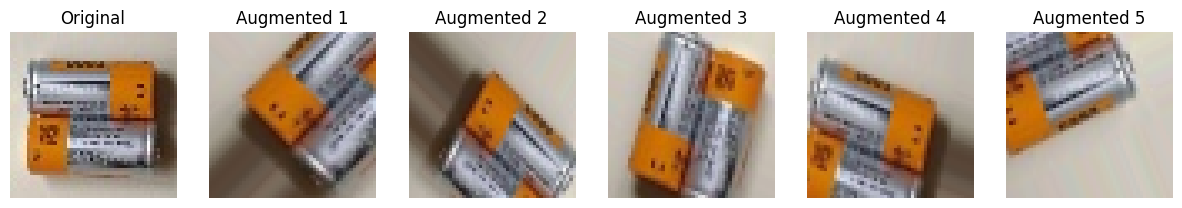

In [7]:
def plot_augmented_images(original, generator, num_images=5):
    # Plotting the original image
    fig, axes = plt.subplots(1, num_images+1, figsize=(15, 5))
    axes[0].imshow(original)
    axes[0].set_title('Original')
    axes[0].axis('off')

    # Plotting the augmented images
    for i in range(1, num_images+1):
        augmented_image = next(generator)[0]
        axes[i].imshow(augmented_image)
        axes[i].set_title(f'Augmented {i}')
        axes[i].axis('off')

    plt.show()

# Load an example image - adjust index as needed
example_image = cv2.imread(train_paths[0])
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
example_image_resized = cv2.resize(example_image, img_size)  # Resize and normalize

# Prepare the image for the generator (add batch dimension, as the generator expects batches)
example_image_batch = np.expand_dims(example_image_resized, axis=0)

# Create a temporary generator for this single image
temp_generator = train_datagen1.flow(
    example_image_batch,
    batch_size=1
)

# Plot the comparison for 5 augmented images
plot_augmented_images(example_image_resized, temp_generator)

## 5. Defining the input_shape

In [8]:
input_shape = example_image_resized.shape
input_shape

(50, 50, 3)

## 6. Weights
Compute class weights to address class imbalance, enhancing model performance in classification tasks.

In [9]:
# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',                         # Set class weights to 'balanced'
    classes=np.unique(train_generator_16_1.classes), # Unique classes in the training data
    y=train_generator_16_1.classes                   # Actual class labels of the training data
)

In [10]:
# Create a dictionary mapping class indices to their respective class weights
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.3681657848324515,
 1: 1.3126057529610828,
 2: 2.128257887517147,
 3: 1.4506778868630201,
 4: 0.24280125195618155,
 5: 2.0563286944996686,
 6: 1.6818428184281842,
 7: 1.2313492063492064,
 8: 1.4947013487475915,
 9: 0.6538137378845343,
 10: 1.8569718731298623,
 11: 1.668279569892473}

## 7. CALLBACKS

In [11]:
# Define the directory to save model checkpoints
checkpoint_dir = "./Callbacks_50"
# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Define a function to create callbacks for model training
def create_model_callbacks(model_name):
    # Create a directory specific to the model
    model_checkpoint_dir = os.path.join(checkpoint_dir, model_name)
    os.makedirs(model_checkpoint_dir, exist_ok=True)

    # Define a ModelCheckpoint callback to save the best model weights based on validation F1 score
    cp_callback_acc = ModelCheckpoint(
        filepath=os.path.join(model_checkpoint_dir, 'best_model_acc.weights.h5'),  # Save path for best model weights
        save_best_only=True,                    # Save only the best model weights
        save_weights_only=True,                 # Save only the model weights
        monitor='val_f1_score',                 # Monitor validation F1 score for saving the best model
        mode='max',                             # Set mode to maximize the F1 score
        verbose=1                               # Display progress updates
    )
    
    # Define an EarlyStopping callback to stop training if validation F1 score does not improve
    early_stopping_callback = EarlyStopping(
        monitor='val_f1_score',                 # Monitor validation F1 score for early stopping
        patience=3,                             # Number of epochs with no improvement before stopping
        mode='max',                             # Set mode to maximize the F1 score
        verbose=1                               # Display progress updates
    )
    
    # Define a ReduceLROnPlateau callback to reduce learning rate if validation F1 score does not improve
    reduce_lr_callback = ReduceLROnPlateau(
        monitor='val_f1_score',                 # Monitor validation F1 score for learning rate reduction
        factor=0.75,                            # Factor by which to reduce the learning rate
        patience=2,                             # Number of epochs with no improvement before reducing learning rate
        mode='min',                             # Set mode to minimize the F1 score
        verbose=1,                              # Display progress updates
        min_lr=0.0001                           # Minimum learning rate threshold
    )

    # Return a list of callbacks
    return [cp_callback_acc, early_stopping_callback, reduce_lr_callback]


## 8. Defining functions to check the model performance

In [12]:
# Define a custom F1Score metric class
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        # Initialize weights to track true positives, false positives, and false negatives
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    # Update state based on true labels and predicted labels
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert labels to boolean values
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.greater_equal(y_pred, 0.5) 
        # Calculate true positives, false positives, and false negatives
        true_positive = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        false_positive = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
        false_negative = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
        
        # Update weights with the sums of true positives, false positives, and false negatives
        self.true_positives.assign_add(tf.reduce_sum(tf.cast(true_positive, self.dtype)))
        self.false_positives.assign_add(tf.reduce_sum(tf.cast(false_positive, self.dtype)))
        self.false_negatives.assign_add(tf.reduce_sum(tf.cast(false_negative, self.dtype)))

    # Calculate F1 score based on current state
    def result(self):
        # Calculate precision and recall
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        # Calculate F1 score
        f1_score = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        return f1_score

    # Reset state to initial values
    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


In [14]:
# Function to plot the F1 and Loss values for both train and validation
def plot_training_history(history):
    # Convert training history to DataFrame
    df_hist = pd.DataFrame.from_dict(history.history)
    df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

    # Create subplots for loss and F1 score curves
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))

    # Plot loss curves
    ax1 = df_hist.plot(x="Epoch", y=['loss', 'val_loss'],
                       kind="line", grid=True, legend=True,
                       ylabel="Categorical cross-entropy", 
                       xlabel="Epoch", title="Loss curves",                  
                       color=['darkred', 'indianred'], alpha=0.75, fontsize=10, ax=axs[0])
    ax1.legend(loc=(0, -0.45), framealpha=1.0)
    ax1.set_ylim([0, 2])  # Set y-axis limits for loss

    # Plot F1 score curves
    ax2 = df_hist.plot(x="Epoch", y=['f1_score', 'val_f1_score'],
                       kind="line", grid=True, legend=True,
                       ylabel="F1 Score", 
                       xlabel="Epoch", title="F1 Score curves",                  
                       color=['darkblue', 'royalblue','green'], alpha=0.75, fontsize=10, ax=axs[1])
    ax2.legend(loc=(0, -0.45), framealpha=1.0)
    ax2.set_ylim([0, 1])  # Set y-axis limits for F1 score


In [15]:
# Function to extract accuracy, F1 Score, and loss, from a given training history based on a specified metric (F1 as default)
def get_metrics(rec, metric='f1_score'):
    # Find the index of the best validation accuracy
    index = np.argmax(rec.history[metric])
    
    # Extract scores based on the index
    acc = rec.history["accuracy"][index]
    f1 = rec.history["f1_score"][index]
    loss = rec.history["loss"][index]
    val_acc = rec.history["val_accuracy"][index]
    val_f1 = rec.history["val_f1_score"][index]
    val_loss = rec.history["val_loss"][index]

    return acc, f1, loss, val_acc, val_f1, val_loss

In [16]:
# Function to compile the model with Adam optimizer
def compile_model_adam(model):
    # Compile the model with F1 score as a metric
    model.compile(optimizer = 'adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', F1Score()])
    return model

In [17]:
def compile_model_SGD(model):
    # Compile the model with F1 score as a metric
    model.compile(optimizer = 'SGD',
                loss='categorical_crossentropy',
                metrics=['accuracy', F1Score()])
    return model

## 9. Models

### 9.1  Linear model and a non-linear model

In [45]:
model_linear = Sequential([
    Conv2D(32, (3, 3), activation=None, input_shape=input_shape),  # No activation
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation=None),  # No activation
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation=None),  # No activation
    MaxPooling2D(2, 2),

    Flatten(), # Flatten the output for dense layers
    Dense(512, activation=None),  # No activation

    Dense(train_generator_16_1.num_classes, activation='softmax') # Output layer with softmax activation
])

# Display model summary
model_linear.summary()

c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,492 (4.38 MB)

 Trainable params: 1,148,492 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Create callbacks for the model
callbacks = create_model_callbacks("history_linear")
model_linear_1 = compile_model_adam(model_linear)

# Train the model with callbacks
history_linear = model_linear_1.fit(
    train_generator_16_2,  # Training data generator
    validation_data=validation_generator_16,  # Validation data generator
    epochs=50,  # Number of epochs for training
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4509 - f1_score: 0.3707 - loss: 1.7019
Epoch 1: val_f1_score improved from -inf to 0.53919, saving model to ./Callbacks_50\history_linear\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4510 - f1_score: 0.3708 - loss: 1.7018 - val_accuracy: 0.5322 - val_f1_score: 0.5392 - val_loss: 1.5057 - learning_rate: 0.0010
Epoch 2/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5348 - f1_score: 0.4882 - loss: 1.4147
Epoch 2: val_f1_score improved from 0.53919 to 0.55514, saving model to ./Callbacks_50\history_linear\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.5348 - f1_score: 0.4882 - loss: 1.4147 - val_accuracy: 0.5714 - val_f1_score: 0.5551 - val_loss: 1.3281 - learning_rate: 0.0010
Epoch 3/50
773/776 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5452 - f1_score: 0.4971 - loss: 1.3758
Epoch 3: val_f1_score improved from 0.55514 to 0.56760, sav

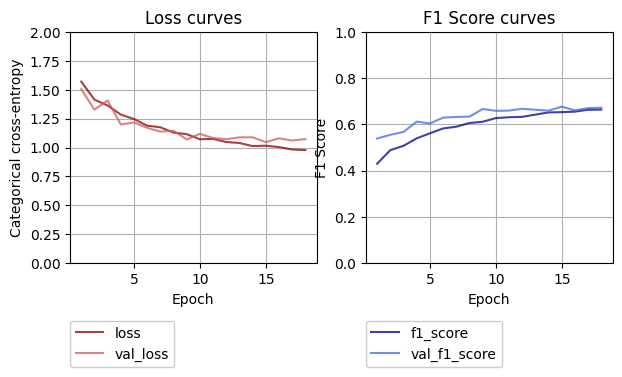

In [47]:
# Get metrics from the training history
acc_linear, f1_linear, loss_linear, val_acc_linear, val_f1_linear, val_loss_linear = get_metrics(history_linear)

# Plotting the results
plot_training_history(history_linear)

In [48]:
# Define the non-linear model architecture
model_non_linear = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # Convolutional layer with ReLU activation
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with ReLU activation
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(128, (3, 3), activation='relu'),  # Convolutional layer with ReLU activation
    MaxPooling2D(2, 2),  # Max pooling layer

    Flatten(),  # Flatten layer to convert 2D feature maps to a vector
    Dense(512, activation='relu'),  # Dense (fully connected) layer with ReLU activation

    Dense(train_generator_16_1.num_classes, activation='softmax')  # Output layer with softmax activation
])

# Display model summary
model_non_linear.summary()


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,494 (4.38 MB)

 Trainable params: 1,148,492 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [49]:
# Create callbacks for the model
callbacks = create_model_callbacks("history_non_linear")

# Compile the model with Adam optimizer
model_non_linear_1 = compile_model_adam(model_non_linear)

# Train the model with callbacks
history_non_linear = model_non_linear_1.fit(
    train_generator_16_2, # Training data generator
    validation_data=validation_generator_16, # Validation data generator
    epochs=50, # Number of epochs for training
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50
773/776 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4178 - f1_score: 0.3136 - loss: 1.7387
Epoch 1: val_f1_score improved from -inf to 0.54187, saving model to ./Callbacks_50\history_non_linear\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4182 - f1_score: 0.3142 - loss: 1.7375 - val_accuracy: 0.5607 - val_f1_score: 0.5419 - val_loss: 1.2557 - learning_rate: 0.0010
Epoch 2/50
775/776 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5629 - f1_score: 0.5278 - loss: 1.2653
Epoch 2: val_f1_score improved from 0.54187 to 0.59205, saving model to ./Callbacks_50\history_non_linear\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.5630 - f1_score: 0.5279 - loss: 1.2651 - val_accuracy: 0.6079 - val_f1_score: 0.5920 - val_loss: 1.1569 - learning_rate: 0.0010
Epoch 3/50
773/776 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6134 - f1_score: 0.5786 - loss: 1.1386
Epoch 3: val_f1_score improved from 0.59205 to 0.66

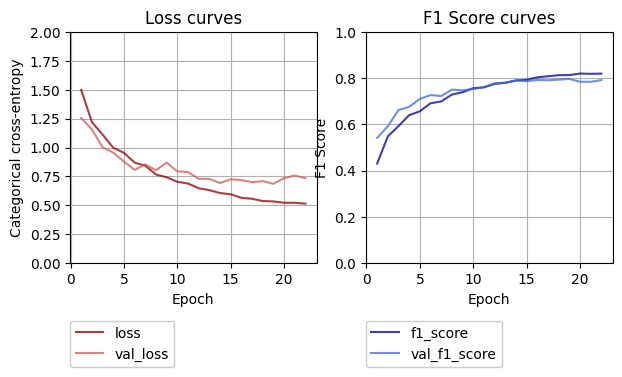

In [50]:
# Get the metrics from the history of the non-linear model
acc_non_linear, f1_non_linear, loss_non_linear, val_acc_non_linear, val_f1_non_linear, val_loss_non_linear = get_metrics(history_non_linear)

# Plot the training history of the non-linear model
plot_training_history(history_non_linear)

In [51]:
data_model = {
    "Model": ["Model_linear", "Model_non_linear"],  # Model names
    "Accuracy": [acc_linear, acc_non_linear],  # Accuracy values
    "F1_Score": [f1_linear, f1_non_linear],  # F1 scores
    "Loss": [loss_linear, loss_non_linear],  # Loss values
    "Val_Accuracy": [val_acc_linear, val_acc_non_linear],  # Validation accuracy values
    "Val_F1_Score": [val_f1_linear, val_f1_non_linear],  # Validation F1 scores
    "Val_Loss": [val_loss_linear, val_loss_non_linear]  # Validation loss values
}

print(pd.DataFrame(data_model))

              Model  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  \
0      Model_linear  0.681598  0.664239  0.977812      0.675081      0.672181   
1  Model_non_linear  0.821705  0.820387  0.521791      0.779807      0.784946   

   Val_Loss  
0  1.072979  
1  0.734780  


Conclusion: The non-linear model achieved better results

### 9.2 Test a model with different data augmentations and without data augmentation

In [18]:
# Model definition
model0 = Sequential([
    # Convolutional layer with 32 filters, each of size 3x3, using ReLU activation function
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    # Max pooling layer with pool size 2x2
    MaxPooling2D(2, 2),

    # Convolutional layer with 64 filters, each of size 3x3, using ReLU activation function
    Conv2D(64, (3, 3), activation='relu'),
    # Max pooling layer with pool size 2x2
    MaxPooling2D(2, 2),

    # Convolutional layer with 128 filters, each of size 3x3, using ReLU activation function
    Conv2D(128, (3, 3), activation='relu'),
    # Max pooling layer with pool size 2x2
    MaxPooling2D(2, 2),

    # Flatten layer to convert 3D feature maps into a 1D feature vector
    Flatten(),
    # Fully connected (dense) layer with 512 neurons, using ReLU activation function
    Dense(512, activation='relu'),

    # Output layer with the number of neurons equal to the number of classes in the training data,
    # using softmax activation function for multiclass classification
    Dense(train_generator_16_1.num_classes, activation='softmax')
])

# Display the summary of the model architecture
model0.summary()


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,492 (4.38 MB)

 Trainable params: 1,148,492 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Create callbacks for the model
callbacks = create_model_callbacks("history01")  # Define callbacks for monitoring the model during training
model01 = compile_model_adam(model0)  # Compile the model with the Adam optimizer and F1 score as a metric

# Train the model with callbacks
history01 = model01.fit(
    train_generator_16_1,  # Training data generator
    validation_data=validation_generator_16,  # Validation data generator
    epochs=50,  # Number of epochs for training
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


775/776 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3973 - f1_score: 0.2629 - loss: 1.8623
Epoch 1: val_f1_score improved from -inf to 0.49760, saving model to ./Callbacks_50\history01\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.3975 - f1_score: 0.2632 - loss: 1.8617 - val_accuracy: 0.5634 - val_f1_score: 0.4976 - val_loss: 1.3323 - learning_rate: 0.0010
Epoch 2/50
775/776 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5277 - f1_score: 0.4792 - loss: 1.3729
Epoch 2: val_f1_score improved from 0.49760 to 0.55026, saving model to ./Callbacks_50\history01\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.5277 - f1_score: 0.4792 - loss: 1.3728 - val_accuracy: 0.6031 - val_f1_score: 0.5503 - val_loss: 1.1823 - learning_rate: 0.0010
Epoch 3/50
775/776 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5734 - f1_score: 0.5319 - loss: 1.2445
Epoch 3: val_f1_score improved from 0.55026 to 0.55997, saving model to ./Callba

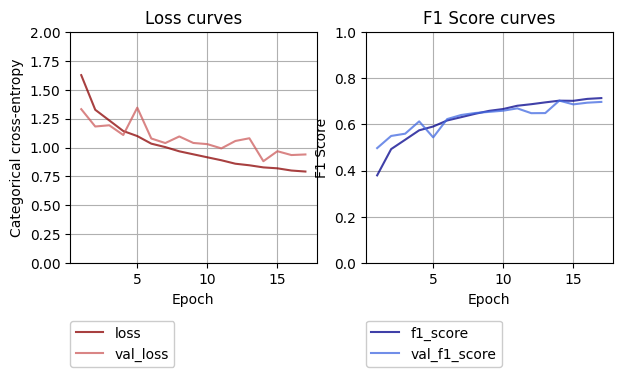

In [20]:
# Evaluate the performance metrics of the model
acc_01, f1_01, loss_01, val_acc_01, val_f1_01, val_loss_01 = get_metrics(history01)

# Plot the training history
plot_training_history(history01)

In [21]:
# Now with a diferrent data augmentation technique

# Define callbacks for the model training
callbacks = create_model_callbacks("history02")

# Compile the model with the Adam optimizer
model02 = compile_model_adam(model0)

# Train the model with callbacks
history02 = model02.fit(
    train_generator_16_2,  # Training data generator
    validation_data=validation_generator_16,  # Validation data generator
    epochs=50,  # Number of epochs for training
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50
  4/776 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.6836 - f1_score: 0.6800 - loss: 0.9081

c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6673 - f1_score: 0.6500 - loss: 0.9802
Epoch 1: val_f1_score improved from -inf to 0.69594, saving model to ./Callbacks_50\history02\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.6673 - f1_score: 0.6500 - loss: 0.9802 - val_accuracy: 0.7041 - val_f1_score: 0.6959 - val_loss: 0.8964 - learning_rate: 0.0010
Epoch 2/50
773/776 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6918 - f1_score: 0.6743 - loss: 0.9059
Epoch 2: val_f1_score did not improve from 0.69594
776/776 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6918 - f1_score: 0.6744 - loss: 0.9059 - val_accuracy: 0.6864 - val_f1_score: 0.6920 - val_loss: 0.9559 - learning_rate: 0.0010
Epoch 3/50
775/776 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7174 - f1_score: 0.6964 - loss: 0.8415
Epoch 3: val_f1_score improved from 0.69594 to 0.71502, saving model to ./Callbacks_50\history02\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 

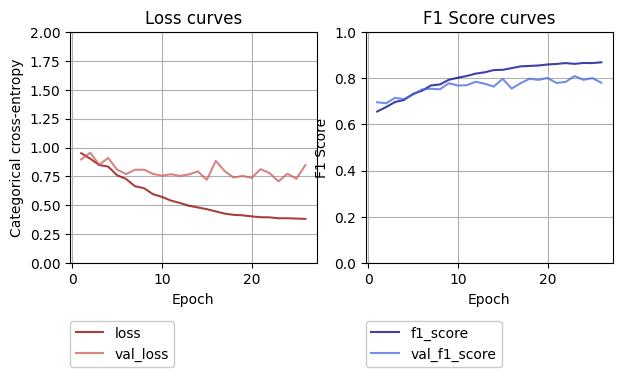

In [22]:
# Retrieve metrics from the training history
acc_02, f1_02, loss_02, val_acc_02, val_f1_02, val_loss_02 = get_metrics(history02)

# Plot the training history
plot_training_history(history02)

In [34]:
# Now without data augmentation

# Create callbacks for the model
callbacks = create_model_callbacks("history03")

# Compile the model with the Adam optimizer
model03 = compile_model_adam(model0)

# Train the model with callbacks
history03 = model03.fit(
    train_generator_16_3,          # Training data generator
    validation_data=validation_generator_16,  # Validation data generator
    epochs=50,                     # Number of epochs for training
    callbacks=callbacks            # Callbacks to be applied during training
)

Epoch 1/50
776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9772 - f1_score: 0.9772 - loss: 0.0768
Epoch 1: val_f1_score improved from -inf to 0.76715, saving model to ./Callbacks_50\history03\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9772 - f1_score: 0.9772 - loss: 0.0768 - val_accuracy: 0.7642 - val_f1_score: 0.7671 - val_loss: 1.6278 - learning_rate: 0.0010
Epoch 2/50
772/776 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9776 - f1_score: 0.9770 - loss: 0.0762
Epoch 2: val_f1_score improved from 0.76715 to 0.77531, saving model to ./Callbacks_50\history03\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9776 - f1_score: 0.9770 - loss: 0.0761 - val_accuracy: 0.7712 - val_f1_score: 0.7753 - val_loss: 1.6467 - learning_rate: 0.0010
Epoch 3/50
771/776 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9891 - f1_score: 0.9895 - loss: 0.0393
Epoch 3: val_f1_score did not improve from 0.77531

Epoch 3: ReduceLR

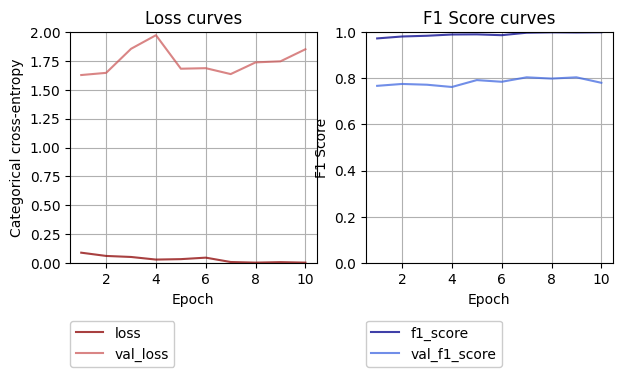

In [35]:
# Obtain evaluation metrics from the training history
acc_03, f1_03, loss_03, val_acc_03, val_f1_03, val_loss_03 = get_metrics(history03)

# Plot the training history
plot_training_history(history03)

In [36]:
data0 = {
    "Model": ["Model01", "Model02", "Model03"],  # Model names
    "Accuracy": [acc_01, acc_02, acc_03],  # Accuracy values
    "F1_Score": [f1_01, f1_02, f1_03],  # F1 scores
    "Loss": [loss_01, loss_02, loss_03],  # Loss values
    "Val_Accuracy": [val_acc_01, val_acc_02, val_acc_03],  # Validation accuracy values
    "Val_F1_Score": [val_f1_01, val_f1_02, val_f1_03],  # Validation F1 scores
    "Val_Loss": [val_loss_01, val_loss_02, val_loss_03]  # Validation loss values
}

print(pd.DataFrame(data0))

     Model  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  Val_Loss
0  Model01  0.726152  0.714111  0.792312      0.691192      0.697551  0.940192
1  Model02  0.870609  0.869026  0.382199      0.777658      0.780665  0.848611
2  Model03  0.999114  0.999033  0.003638      0.777658      0.780330  1.850974


With this simple model, I've provided the model with two different types of data augmentation processes. From now on, for simplicity, I will proceed with the second data augmentation format as it achieved better results.

### 9.3 Test a model with different optimization functions with the model defined earlier

In [79]:
# Create callbacks for the model
callbacks = create_model_callbacks("history04")

# Compile the model with the Adam optimizer
model04 = compile_model_adam(model0)

# Train the model with callbacks
history04 = model04.fit(
    train_generator_16_2,  # Training data generator
    validation_data=validation_generator_16,  # Validation data generator
    epochs=50,  # Number of epochs for training
    callbacks=callbacks  # Callbacks to be applied during training
)


Epoch 1/50
773/776 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8410 - f1_score: 0.8418 - loss: 0.4772
Epoch 1: val_f1_score improved from -inf to 0.77231, saving model to ./Callbacks_50\history04\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.8410 - f1_score: 0.8417 - loss: 0.4774 - val_accuracy: 0.7707 - val_f1_score: 0.7723 - val_loss: 0.9552 - learning_rate: 0.0010
Epoch 2/50
773/776 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8353 - f1_score: 0.8375 - loss: 0.4884
Epoch 2: val_f1_score did not improve from 0.77231
776/776 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.8353 - f1_score: 0.8374 - loss: 0.4884 - val_accuracy: 0.7487 - val_f1_score: 0.7575 - val_loss: 1.0674 - learning_rate: 0.0010
Epoch 3/50
775/776 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8395 - f1_score: 0.8375 - loss: 0.4882
Epoch 3: val_f1_score did not improve from 0.77231
776/776 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.8395 - f1_score: 0.8375 - loss: 0

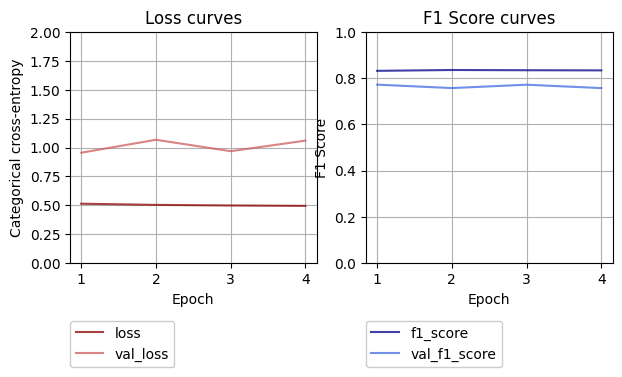

In [80]:
# Retrieve metrics from the training history of model04
acc_04, f1_04, loss_04, val_acc_04, val_f1_04, val_loss_04 = get_metrics(history04)

# Plot the training history of model04
plot_training_history(history04)

In [81]:
# Create callbacks for the model
callbacks = create_model_callbacks("history05")  # Define callbacks to monitor the training progress
model05 = compile_model_SGD(model0)  # Compile the model with SGD optimizer

# Train the model with callbacks
history05 = model05.fit(
    train_generator_16_2,  # Training data generator
    validation_data=validation_generator_16,  # Validation data generator
    epochs=50,  # Number of epochs for training
    callbacks=callbacks  # Apply defined callbacks during training
)

Epoch 1/50
771/776 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7937 - f1_score: 0.7913 - loss: 0.6343
Epoch 1: val_f1_score improved from -inf to 0.74182, saving model to ./Callbacks_50\history05\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7938 - f1_score: 0.7914 - loss: 0.6339 - val_accuracy: 0.7352 - val_f1_score: 0.7418 - val_loss: 1.1384 - learning_rate: 0.0100
Epoch 2/50
775/776 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8277 - f1_score: 0.8300 - loss: 0.5139
Epoch 2: val_f1_score improved from 0.74182 to 0.77297, saving model to ./Callbacks_50\history05\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8277 - f1_score: 0.8300 - loss: 0.5139 - val_accuracy: 0.7707 - val_f1_score: 0.7730 - val_loss: 0.9915 - learning_rate: 0.0100
Epoch 3/50
772/776 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8278 - f1_score: 0.8305 - loss: 0.5234
Epoch 3: val_f1_score did not improve from 0.77297

Epoch 3: ReduceLR

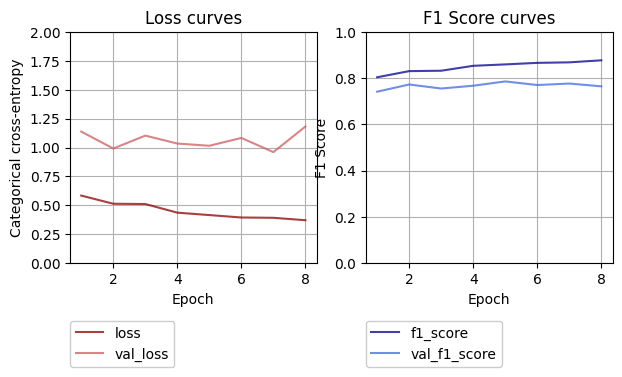

In [82]:
# Extracting metrics from the training history
acc_05, f1_05, loss_05, val_acc_05, val_f1_05, val_loss_05 = get_metrics(history05)

# Plotting the training history
plot_training_history(history05)

In [83]:
data_0 = {
    "Model": ["Model04", "Model05"],  # Model names
    "Accuracy": [acc_04, acc_05],  # Accuracy values
    "F1_Score": [f1_04, f1_05],  # F1 scores
    "Loss": [loss_04, loss_05],  # Loss values
    "Val_Accuracy": [val_acc_04, val_acc_05],  # Validation accuracy values
    "Val_F1_Score": [val_f1_04, val_f1_05],  # Validation F1 scores
    "Val_Loss": [val_loss_04, val_loss_05]  # Validation loss values
}

print(pd.DataFrame(data_0))

     Model  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  Val_Loss
0  Model04  0.832340  0.835707  0.503655      0.748657      0.757508  1.067369
1  Model05  0.877135  0.877586  0.370832      0.758861      0.765015  1.182155


The optimizer SGD achieved better results, but I will test it again when I create a more complex CNN in the Manual GridSearch.

### 9.4 Create a batch size of 32 and 64 for the second data augmentation formatation

In [43]:
print("Batch size : 32")

# Generating batches of augmented training data from the directory
train_generator_32 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=img_size,  # Resizing all images to 50x50
    batch_size=32,         # Number of images to return in each batch
    class_mode=label_mode  # Type of labels provided
)

# Generating batches of validation data
validation_generator_32 = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,  # Resizing all images to 50x50
    batch_size=32,         # Number of images to return in each batch
    class_mode=label_mode  # Type of labels provided
)

Batch size : 32
Found 12412 images belonging to 12 classes.
Found 1862 images belonging to 12 classes.


In [44]:
print("Batch size : 64")

# Generating batches of augmented training data from the directory
train_generator_64 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=img_size,  # Resizing all images to 50x50
    batch_size=64,         # Number of images to return in each batch
    class_mode=label_mode  # Type of labels provided
)

# Generating batches of validation data
validation_generator_64 = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,  # Resizing all images to 50x50
    batch_size=64,         # Number of images to return in each batch
    class_mode=label_mode  # Type of labels provided
)


Batch size : 64
Found 12412 images belonging to 12 classes.
Found 1862 images belonging to 12 classes.


#### 9.4.1 Since I have several different batch sizes, I will create a model to check if any of them outperform the others. I will also test if class_weights influence the imbalance class classification. I'll keep the simplest model possible defined earlier.


#####  9.4.1.1 Batch size: 16, Class weights: yes

In [52]:
# Create callbacks for the model
callbacks = create_model_callbacks("history12")

# Compile the model with the SGD optimizer
model12 = compile_model_SGD(model0)

# Train the model with callbacks
history12 = model12.fit(
    train_generator_16_2,        # Training data generator
    epochs=50,                    # Number of epochs for training
    validation_data=validation_generator_16,  # Validation data generator
    class_weight=class_weights_dict,          # Class weights to handle class imbalance
    callbacks=callbacks           # Callbacks to be applied during training
)

Epoch 1/50
771/776 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6141 - f1_score: 0.6086 - loss: 1.4294
Epoch 1: val_f1_score improved from -inf to 0.73435, saving model to ./Callbacks_50\history12\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6145 - f1_score: 0.6090 - loss: 1.4271 - val_accuracy: 0.7282 - val_f1_score: 0.7344 - val_loss: 1.0221 - learning_rate: 0.0100
Epoch 2/50
771/776 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7160 - f1_score: 0.7140 - loss: 0.8639
Epoch 2: val_f1_score improved from 0.73435 to 0.74323, saving model to ./Callbacks_50\history12\best_model_acc.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7160 - f1_score: 0.7141 - loss: 0.8638 - val_accuracy: 0.7438 - val_f1_score: 0.7432 - val_loss: 1.0409 - learning_rate: 0.0100
Epoch 3/50
774/776 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7551 - f1_score: 0.7547 - loss: 0.7820
Epoch 3: val_f1_score did not improve from 0.74323

Epoch 3: ReduceLR

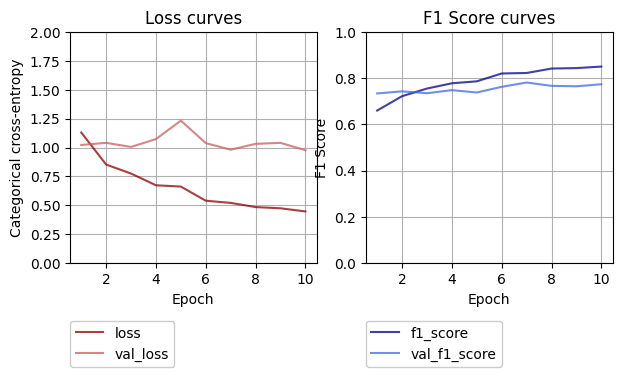

In [53]:
# Extracting metrics from the training history
acc_12, f1_12, loss_12, val_acc_12, val_f1_12, val_loss_12 = get_metrics(history12)

# Plotting the training history
plot_training_history(history12)

##### 9.4.1.2 Batch size: 32, Class weights: no

In [54]:
# Create callbacks for the model
callbacks = create_model_callbacks("history13")

# Compile the model with the SGD optimizer
model13 = compile_model_SGD(model0)

# Train the model with callbacks
history13 = model13.fit(
    train_generator_32,  # Training data generator
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator_32,  # Validation data generator
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8566 - f1_score: 0.8594 - loss: 0.4272
Epoch 1: val_f1_score improved from -inf to 0.77271, saving model to ./Callbacks_50\history13\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.8566 - f1_score: 0.8594 - loss: 0.4272 - val_accuracy: 0.7691 - val_f1_score: 0.7727 - val_loss: 1.0664 - learning_rate: 0.0100
Epoch 2/50
386/388 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8563 - f1_score: 0.8565 - loss: 0.4136
Epoch 2: val_f1_score improved from 0.77271 to 0.77860, saving model to ./Callbacks_50\history13\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.8563 - f1_score: 0.8565 - loss: 0.4135 - val_accuracy: 0.7728 - val_f1_score: 0.7786 - val_loss: 0.9964 - learning_rate: 0.0100
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8604 - f1_score: 0.8603 - loss: 0.4235
Epoch 3: val_f1_score improved from 0.77860 to 0.79579, saving model to ./Callba

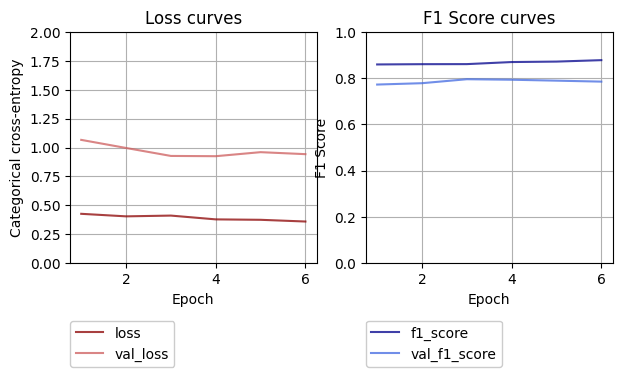

In [55]:
# Extracting metrics from the training history
acc_13, f1_13, loss_13, val_acc_13, val_f1_13, val_loss_13 = get_metrics(history13)

# Plotting the training history
plot_training_history(history13)

##### 9.4.1.3 Batch size: 32, Class weights: yes

In [56]:
# Define callbacks for the model
callbacks = create_model_callbacks("history14")

# Compile the model with the SGD optimizer
model14 = compile_model_SGD(model0)

# Train the model with the specified parameters and callbacks
history14 = model14.fit(
    train_generator_32,  # Training data generator
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator_32,  # Validation data generator
    class_weight=class_weights_dict,  # Class weights for handling class imbalance
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50
386/388 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8410 - f1_score: 0.8434 - loss: 0.5087
Epoch 1: val_f1_score improved from -inf to 0.77410, saving model to ./Callbacks_50\history14\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.8410 - f1_score: 0.8435 - loss: 0.5086 - val_accuracy: 0.7728 - val_f1_score: 0.7741 - val_loss: 0.9620 - learning_rate: 0.0100
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8356 - f1_score: 0.8360 - loss: 0.5037
Epoch 2: val_f1_score did not improve from 0.77410
388/388 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.8355 - f1_score: 0.8360 - loss: 0.5038 - val_accuracy: 0.7610 - val_f1_score: 0.7681 - val_loss: 0.9472 - learning_rate: 0.0100
Epoch 3/50
386/388 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8349 - f1_score: 0.8335 - loss: 0.5085
Epoch 3: val_f1_score improved from 0.77410 to 0.77588, saving model to ./Callbacks_50\history14\best_model_acc.weights.h5
388/388 ━━━━━━━━━━

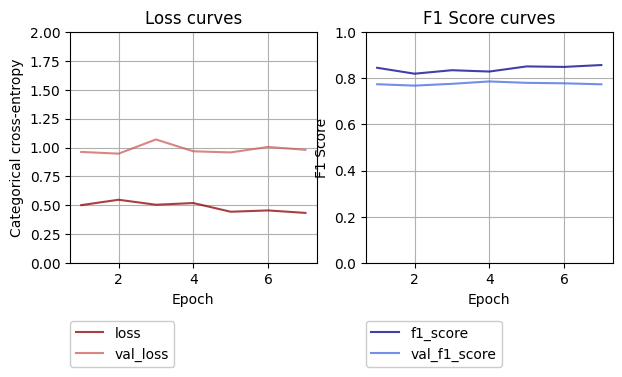

In [57]:
# Retrieve metrics from the training history
acc_14, f1_14, loss_14, val_acc_14, val_f1_14, val_loss_14 = get_metrics(history14)

# Plot the training history
plot_training_history(history14)

##### 9.4.1.4 Batch size: 64, Class weights: no

In [58]:
# Create callbacks for the model
callbacks = create_model_callbacks("history15")  # Define callbacks for model training
model15 = compile_model_SGD(model0)  # Compile the model with SGD optimizer

# Train the model with callbacks
history15 = model15.fit(
    train_generator_64,  # Training data generator
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator_64,  # Validation data generator
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8756 - f1_score: 0.8743 - loss: 0.3679
Epoch 1: val_f1_score improved from -inf to 0.80022, saving model to ./Callbacks_50\history15\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.8757 - f1_score: 0.8743 - loss: 0.3678 - val_accuracy: 0.7965 - val_f1_score: 0.8002 - val_loss: 0.9270 - learning_rate: 0.0100
Epoch 2/50
193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8800 - f1_score: 0.8787 - loss: 0.3520
Epoch 2: val_f1_score improved from 0.80022 to 0.80331, saving model to ./Callbacks_50\history15\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.8800 - f1_score: 0.8788 - loss: 0.3518 - val_accuracy: 0.8024 - val_f1_score: 0.8033 - val_loss: 0.9082 - learning_rate: 0.0100
Epoch 3/50
193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8851 - f1_score: 0.8871 - loss: 0.3416
Epoch 3: val_f1_score did not improve from 0.80331
194/194 ━━━━━━━━━━━━━━━━━━━━ 

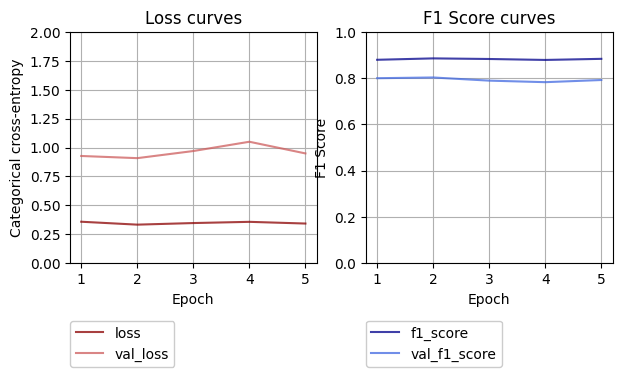

In [59]:
# Retrieve metrics from the training history
acc_15, f1_15, loss_15, val_acc_15, val_f1_15, val_loss_15 = get_metrics(history15)

# Plotting the results
plot_training_history(history15)

##### 9.4.1.5 Batch size: 64, Class weights: yes

In [60]:
# Create callbacks for the model
callbacks = create_model_callbacks("history16")

# Compile the model with SGD optimizer
model16 = compile_model_SGD(model0)

history16 = model16.fit(
    train_generator_64, # Training data generator
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator_64, # Validation data generator
    class_weight=class_weights_dict, # Class weights for handling class imbalance
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50
193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8666 - f1_score: 0.8674 - loss: 0.4134
Epoch 1: val_f1_score improved from -inf to 0.77580, saving model to ./Callbacks_50\history16\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.8665 - f1_score: 0.8673 - loss: 0.4136 - val_accuracy: 0.7728 - val_f1_score: 0.7758 - val_loss: 0.9962 - learning_rate: 0.0100
Epoch 2/50
193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8602 - f1_score: 0.8620 - loss: 0.4173
Epoch 2: val_f1_score improved from 0.77580 to 0.78352, saving model to ./Callbacks_50\history16\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.8601 - f1_score: 0.8619 - loss: 0.4174 - val_accuracy: 0.7830 - val_f1_score: 0.7835 - val_loss: 0.9578 - learning_rate: 0.0100
Epoch 3/50
193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8566 - f1_score: 0.8588 - loss: 0.4084
Epoch 3: val_f1_score improved from 0.78352 to 0.78567, saving model 

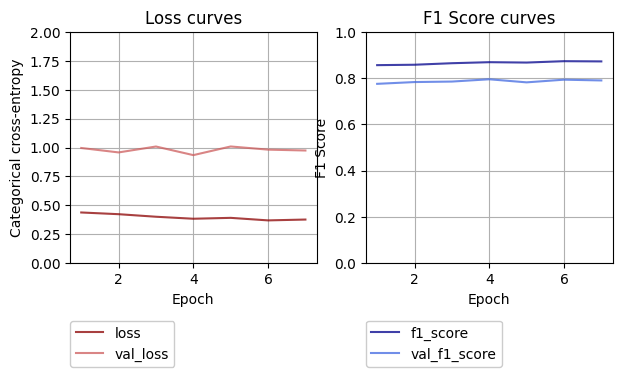

In [61]:
# Get the metrics from the training history
acc_16, f1_16, loss_16, val_acc_16, val_f1_16, val_loss_16 = get_metrics(history16)

# Plot the training history
plot_training_history(history16)

##### 9.4.1.6 Let's make a small comparison to check if any of them outperforms the others

In [62]:
# Create a dictionary to store the information
data1 = {
    "Model": ["Model02", "Model12", "Model13", "Model14", "Model15", "Model16"],  # Model names
    "Accuracy": [acc_02, acc_12, acc_13, acc_14, acc_15, acc_16],  # Accuracy values
    "F1_Score": [f1_02, f1_12, f1_13, f1_14, f1_15, f1_16],  # F1 scores
    "Loss": [loss_02, loss_12, loss_13, loss_14, loss_15, loss_16],  # Loss values
    "Val_Accuracy": [val_acc_02, val_acc_12, val_acc_13, val_acc_14, val_acc_15, val_acc_16],  # Validation accuracy values
    "Val_F1_Score": [val_f1_02, val_f1_12, val_f1_13, val_f1_14, val_f1_15, val_f1_16],  # Validation F1 scores
    "Val_Loss": [val_loss_02, val_loss_12, val_loss_13, val_loss_14, val_loss_15, val_loss_16]  # Validation loss values
}

print(pd.DataFrame(data1))

     Model  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  Val_Loss
0  Model02  0.870609  0.869026  0.382199      0.777658      0.780665  0.848611
1  Model12  0.848614  0.850555  0.446756      0.770677      0.773944  0.976925
2  Model13  0.878021  0.878322  0.359546      0.781955      0.785418  0.942821
3  Model14  0.855785  0.857202  0.434142      0.771214      0.773819  0.980274
4  Model15  0.886239  0.885986  0.332502      0.802363      0.803310  0.908241
5  Model16  0.872059  0.873868  0.369356      0.788400      0.793826  0.982000


WHAT CAN I SAY ABOUT THE BATCH SIZE?

After this, I concluded that a batch size of 16 produces the worst results, so I will decide to increase the batch size to 32 or 64.

WHAT CAN I SAY ABOUT THE CLASS_WEIGHTS?

Unbelievably, the models that use the class_weights dictionary don't perform better compared to the ones that don't. So, I will continue testing.

### 9.5 Model V2 - More complex model

The current model is a deeper and more complex network when compared to the previous one, with additional convolutional and pooling layers (increased  capacity to learn patterns in the data) and more neurons on the Dense layer. I also used 'same' padding in all convolutional layers (the spatial dimensions of the output feature maps are the same as the input dimensions).

However, this increased complexity leads to a higher computational cost and potential risk of overfitting.


In [63]:
# Define a more complex model architecture with added layers for increased complexity
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Apply batch normalization to normalize the activations
    MaxPooling2D(2, 2),  # Max pooling layer for downsampling

    Conv2D(64, (3, 3), activation='relu'),  # Another convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization
    MaxPooling2D(2, 2),  # Max pooling

    Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization
    MaxPooling2D(2, 2),  # Max pooling

    Flatten(),  # Flatten the input for the fully connected layers
    Dense(256, activation='relu'),  # Fully connected layer with ReLU activation
    BatchNormalization(),  # Batch normalization
    Dropout(0.2),  # Dropout layer to prevent overfitting

    Dense(train_generator_32.num_classes, activation='softmax')  # Output layer with softmax activation for classification
])

# Display the model summary to show the architecture and parameter counts
model2.summary()


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 622,796 (2.38 MB)

 Trainable params: 621,836 (2.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [64]:
# Create callbacks for the model
callbacks = create_model_callbacks("history24")  # Define callbacks for monitoring and saving the model
model24 = compile_model_SGD(model2)  # Compile the model with SGD optimizer

# Train the model with the specified generator and validation data, along with defined callbacks
history24 = model24.fit(
    train_generator_32,  # Training data generator
    epochs=50,  # Set the number of epochs for training
    validation_data=validation_generator_32,  # Validation data generator
    class_weight=class_weights_dict,  # Assign class weights to handle class imbalance
    callbacks=callbacks  # Apply defined callbacks during training
)


Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3156 - f1_score: 0.2550 - loss: 2.1237
Epoch 1: val_f1_score improved from -inf to 0.23291, saving model to ./Callbacks_50\history24\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.3158 - f1_score: 0.2553 - loss: 2.1230 - val_accuracy: 0.3829 - val_f1_score: 0.2329 - val_loss: 1.8861 - learning_rate: 0.0100
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4840 - f1_score: 0.4418 - loss: 1.5770
Epoch 2: val_f1_score improved from 0.23291 to 0.29724, saving model to ./Callbacks_50\history24\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.4840 - f1_score: 0.4418 - loss: 1.5769 - val_accuracy: 0.3013 - val_f1_score: 0.2972 - val_loss: 2.4458 - learning_rate: 0.0100
Epoch 3/50
387/388 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5354 - f1_score: 0.4904 - loss: 1.4389
Epoch 3: val_f1_score improved from 0.29724 to 0.55615, saving model 

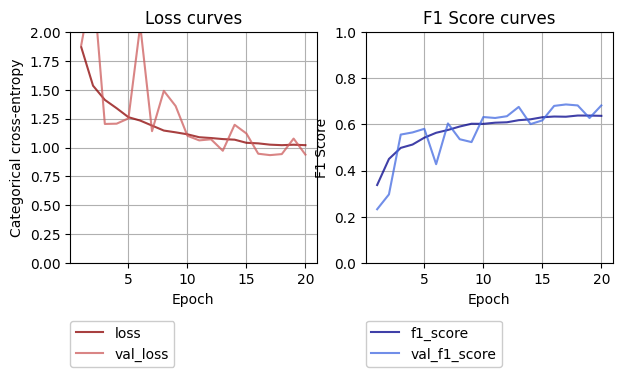

In [65]:
# Extracting evaluation metrics
acc_24, f1_24, loss_24, val_acc_24, val_f1_24, val_loss_24 = get_metrics(history24)

# Plotting the results
plot_training_history(history24)

In [66]:
# Create callbacks for the model
callbacks = create_model_callbacks("history26")  # Define callbacks for monitoring and saving the model
model26 = compile_model_SGD(model2)  # Compile the model with SGD optimizer

# Train the model with the specified generator and validation data, along with defined callbacks
history26 = model26.fit(
    train_generator_64,  # Training data generator
    epochs=50,  # Set the number of epochs for training
    validation_data=validation_generator_64,  # Validation data generator
    class_weight=class_weights_dict,  # Assign class weights to handle class imbalance
    callbacks=callbacks  # Apply defined callbacks during training
)

Epoch 1/50
193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6683 - f1_score: 0.6444 - loss: 1.0098
Epoch 1: val_f1_score improved from -inf to 0.69485, saving model to ./Callbacks_50\history26\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.6682 - f1_score: 0.6443 - loss: 1.0100 - val_accuracy: 0.6890 - val_f1_score: 0.6949 - val_loss: 0.9466 - learning_rate: 0.0100
Epoch 2/50
193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6602 - f1_score: 0.6412 - loss: 1.0118
Epoch 2: val_f1_score did not improve from 0.69485
194/194 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.6602 - f1_score: 0.6412 - loss: 1.0118 - val_accuracy: 0.6316 - val_f1_score: 0.6237 - val_loss: 1.1340 - learning_rate: 0.0100
Epoch 3/50
193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6647 - f1_score: 0.6477 - loss: 1.0015
Epoch 3: val_f1_score did not improve from 0.69485
194/194 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.6647 - f1_score: 0.6477 - loss: 

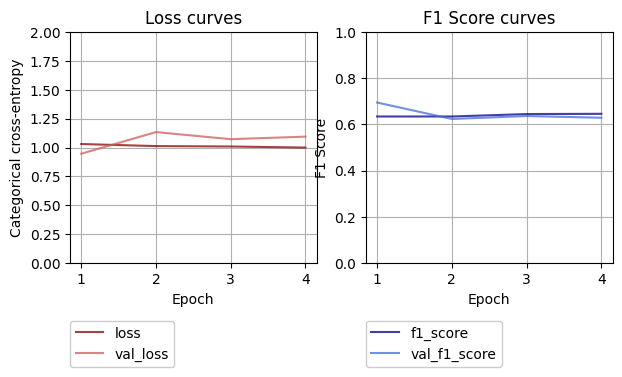

In [67]:
# Extracting evaluation metrics
acc_26, f1_26, loss_26, val_acc_26, val_f1_26, val_loss_26 = get_metrics(history26)

# Plotting the results
plot_training_history(history26)

In [68]:
# Update data2 with the new values
data2 = {
    "Model": ["Model24", "Model26"],  # Updated model names
    "Accuracy": [acc_24, acc_26],  # Updated accuracy values
    "F1_Score": [f1_24, f1_26],  # Updated F1 score values
    "Loss": [loss_24, loss_26],  # Updated loss values
    "Val_Accuracy": [val_acc_24, val_acc_26],  # Updated validation accuracy values
    "Val_F1_Score": [val_f1_24, val_f1_26],  # Updated validation F1 score values
    "Val_Loss": [val_loss_24, val_loss_26]  # Updated validation loss values
}

# Print the updated data2
print(pd.DataFrame(data2))

     Model  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  Val_Loss
0  Model24  0.656300  0.638582  1.020644      0.691192      0.682303  0.943453
1  Model26  0.666774  0.646026  0.999833      0.628894      0.629008  1.094422


### 9.6 MODEL 3

Adding more layers to achieve a more complex CNN.

In [69]:
# Define the architecture of the model
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3), padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer

    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(512, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(1024, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Flatten(),  # Flatten layer to convert 2D feature maps to 1D feature vectors
    Dense(256, activation='relu'),  # Dense layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    Dropout(0.2),  # Dropout layer for regularization

    Dense(train_generator_16_1.num_classes, activation='softmax')  # Output layer with softmax activation
])

model3.summary()  # Display model summary

c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 3, 3, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 3, 3, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,562,764 (25.03 MB)

 Trainable params: 6,558,220 (25.02 MB)

 Non-trainable params: 4,544 (17.75 KB)

In [70]:
# SGD optimizer and batch size 32

# Create callbacks for the model
callbacks = create_model_callbacks("history34")  # Callbacks for model training
model34 = compile_model_SGD(model3)  # Compile the model with SGD optimizer

# Train the model
history34 = model34.fit(
    train_generator_32,  # Training data generator 32 batch size 
    epochs=50,  # Number of epochs
    validation_data=validation_generator_32,  # Validation data generator
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4468 - f1_score: 0.4222 - loss: 1.8499
Epoch 1: val_f1_score improved from -inf to 0.38661, saving model to ./Callbacks_50\history34\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 63s 156ms/step - accuracy: 0.4470 - f1_score: 0.4224 - loss: 1.8491 - val_accuracy: 0.3566 - val_f1_score: 0.3866 - val_loss: 2.5679 - learning_rate: 0.0100
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5819 - f1_score: 0.5689 - loss: 1.2660
Epoch 2: val_f1_score improved from 0.38661 to 0.59187, saving model to ./Callbacks_50\history34\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 61s 157ms/step - accuracy: 0.5820 - f1_score: 0.5689 - loss: 1.2659 - val_accuracy: 0.5934 - val_f1_score: 0.5919 - val_loss: 1.2356 - learning_rate: 0.0100
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.6316 - f1_score: 0.6162 - loss: 1.1160
Epoch 3: val_f1_score did not improve from 0.59187

Epoch 3: Red

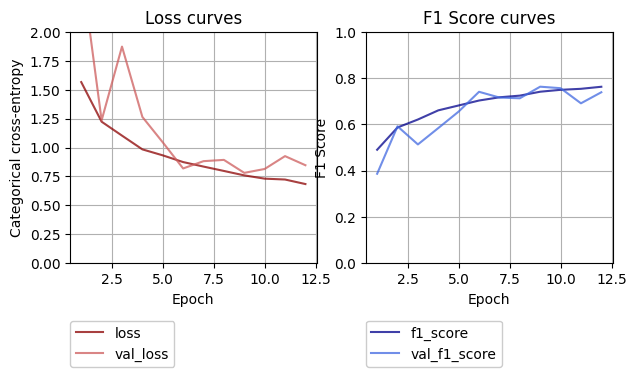

In [71]:
# Extracting evaluation metrics
acc_34, f1_34, loss_34, val_acc_34, val_f1_34, val_loss_34 = get_metrics(history34)

# Plotting the results
plot_training_history(history34)

In [72]:
# SGD optimizer and batch size 64

# Create callbacks for the model
callbacks = create_model_callbacks("history36")  # Callbacks for model training
model36 = compile_model_SGD(model3)  # Compile the model with SGD optimizer

# Train the model
history36 = model36.fit(
    train_generator_64,  # Training data generator 64 batch size
    epochs=50,  # Number of epochs
    validation_data=validation_generator_64,  # Validation data generator
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7725 - f1_score: 0.7682 - loss: 0.6828
Epoch 1: val_f1_score improved from -inf to 0.67445, saving model to ./Callbacks_50\history36\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 59s 295ms/step - accuracy: 0.7725 - f1_score: 0.7682 - loss: 0.6828 - val_accuracy: 0.6686 - val_f1_score: 0.6745 - val_loss: 1.0054 - learning_rate: 0.0100
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7766 - f1_score: 0.7739 - loss: 0.6636
Epoch 2: val_f1_score improved from 0.67445 to 0.72526, saving model to ./Callbacks_50\history36\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 58s 297ms/step - accuracy: 0.7766 - f1_score: 0.7739 - loss: 0.6637 - val_accuracy: 0.7234 - val_f1_score: 0.7253 - val_loss: 0.8642 - learning_rate: 0.0100
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7842 - f1_score: 0.7798 - loss: 0.6422
Epoch 3: val_f1_score did not improve from 0.72526

Epoch 3: Red

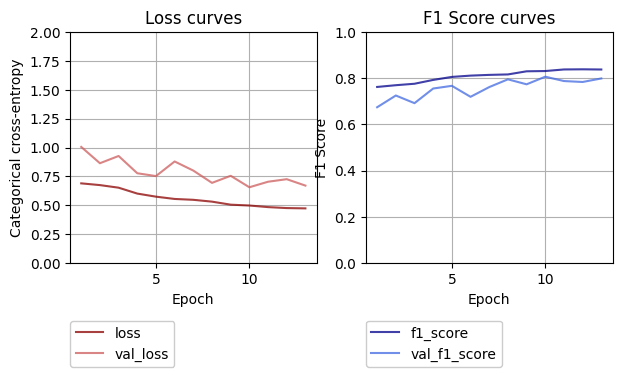

In [73]:
# Extracting evaluation metrics
acc_36, f1_36, loss_36, val_acc_36, val_f1_36, val_loss_36 = get_metrics(history36)

# Plotting the results
plot_training_history(history36)

In [85]:
# adam optimizer and batch size 32

# Create callbacks for the model
callbacks = create_model_callbacks("history38")
model38 = compile_model_adam(model3) # Compile the model with adam optimizer

# Train the model with callbacks
history38 = model38.fit(
    train_generator_32,  # Training data generator 32 batch size
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator_32,  # Validation data generator
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5573 - f1_score: 0.5407 - loss: 1.4280
Epoch 1: val_f1_score improved from -inf to 0.49212, saving model to ./Callbacks_50\history38\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 72s 175ms/step - accuracy: 0.5573 - f1_score: 0.5408 - loss: 1.4277 - val_accuracy: 0.4898 - val_f1_score: 0.4921 - val_loss: 1.8271 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6374 - f1_score: 0.6246 - loss: 1.0896
Epoch 2: val_f1_score improved from 0.49212 to 0.61274, saving model to ./Callbacks_50\history38\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 68s 176ms/step - accuracy: 0.6375 - f1_score: 0.6247 - loss: 1.0896 - val_accuracy: 0.6192 - val_f1_score: 0.6127 - val_loss: 1.2137 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6928 - f1_score: 0.6838 - loss: 0.9470
Epoch 3: val_f1_score improved from 0.61274 to 0.70009, saving m

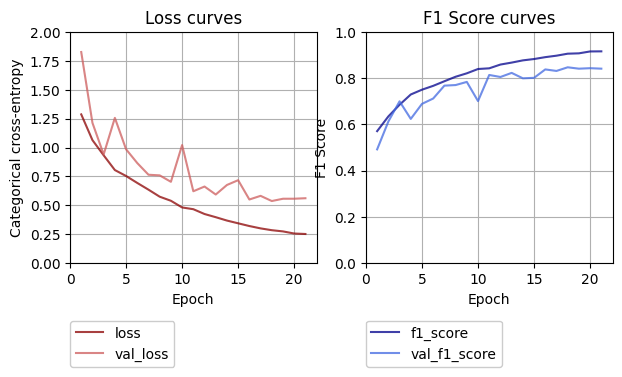

In [86]:
# Extracting evaluation metrics
acc_38, f1_38, loss_38, val_acc_38, val_f1_38, val_loss_38 = get_metrics(history38)

# Plotting the results
plot_training_history(history38)

In [87]:
# adam optimizer and batch size 64

# Create callbacks for the model
callbacks = create_model_callbacks("history39")
model39 = compile_model_adam(model3) # Compile the model with adam optimizer

# Train the model with callbacks
history39 = model39.fit(
    train_generator_64,  # Training data generator
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator_64,  # Validation data generator
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.8594 - f1_score: 0.8619 - loss: 0.4254
Epoch 1: val_f1_score improved from -inf to 0.77549, saving model to ./Callbacks_50\history39\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 66s 320ms/step - accuracy: 0.8594 - f1_score: 0.8619 - loss: 0.4255 - val_accuracy: 0.7728 - val_f1_score: 0.7755 - val_loss: 0.8023 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.8659 - f1_score: 0.8639 - loss: 0.3991
Epoch 2: val_f1_score did not improve from 0.77549
194/194 ━━━━━━━━━━━━━━━━━━━━ 62s 318ms/step - accuracy: 0.8658 - f1_score: 0.8639 - loss: 0.3992 - val_accuracy: 0.7503 - val_f1_score: 0.7524 - val_loss: 0.9753 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.8587 - f1_score: 0.8588 - loss: 0.4150
Epoch 3: val_f1_score did not improve from 0.77549
194/194 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.8587 - f1_score: 0.8588 - l

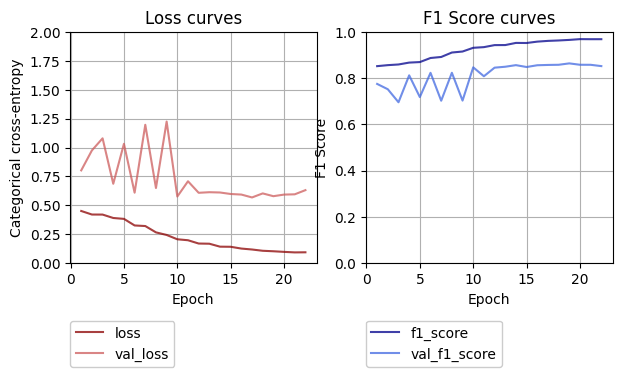

In [88]:
# Extracting evaluation metrics
acc_39, f1_39, loss_39, val_acc_39, val_f1_39, val_loss_39 = get_metrics(history39)

# Plotting the results
plot_training_history(history39)

In [89]:
# Update data3 with corrected model names
data3 = {
    "Model": ["Model34", "Model36", "Model38", "Model39"],  # Updated model names
    "Accuracy": [acc_34, acc_36, acc_38, acc_39],  # Updated accuracy values
    "F1_Score": [f1_34, f1_36, f1_38, f1_39],  # Updated F1 score values
    "Loss": [loss_34, loss_36, loss_38, loss_39],  # Updated loss values
    "Val_Accuracy": [val_acc_34, val_acc_36, val_acc_38, val_acc_39],  # Updated validation accuracy values
    "Val_F1_Score": [val_f1_34, val_f1_36, val_f1_38, val_acc_39],  # Updated validation F1 score values
    "Val_Loss": [val_loss_34, val_loss_36, val_loss_38, val_loss_39]  # Updated validation loss values
}

# Print the updated data3
print(pd.DataFrame(data3))

     Model  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  Val_Loss
0  Model34  0.769820  0.763174  0.683985      0.734694      0.739369  0.847036
1  Model36  0.840638  0.838704  0.475987      0.780344      0.783860  0.726065
2  Model38  0.916532  0.916464  0.251606      0.836198      0.841527  0.561184
3  Model39  0.969143  0.969351  0.096738      0.854995      0.854995  0.592729


## 9.7 Model 4 - Deep CNN with Regularization Techniques
The main difference of this model is the incorporation of L2 regularization in the first dense layer to control overfitting. I also kept a dropout regularization to further prevent co-adaptation of neurons during training. 

In [75]:
# Define the model architecture
model4 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(50, 50, 3)),  # 64 filters with relu activation
    BatchNormalization(),  # Batch normalization
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(128, (3, 3), activation='relu'),  # 128 filters with relu activation
    BatchNormalization(),  # Batch normalization
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(256, (3, 3), activation='relu'),  # 256 filters with relu activation
    BatchNormalization(),  # Batch normalization
    MaxPooling2D(2, 2),  # Max pooling layer

    Flatten(),  # Flatten layer to convert 2D data to 1D
    Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Dense layer with relu activation and L2 regularization
    BatchNormalization(),  # Batch normalization
    Dropout(0.2),  # Dropout layer with dropout rate of 0.2

    Dense(train_generator_64.num_classes, activation='softmax')  # Output layer with softmax activation
])

# Print model summary
model4.summary()

c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425,548 (5.44 MB)

 Trainable params: 1,424,140 (5.43 MB)

 Non-trainable params: 1,408 (5.50 KB)

### 9.7.1 Model with a batch size of 64, no class weights and adam optimizer

In [76]:
# Create callbacks for the model
callbacks = create_model_callbacks("history46")  # Define callbacks for monitoring and improving the model during training
model46 = compile_model_adam(model4)  # Compile the model with Adam optimizer

history46 = model46.fit(  # Train the model
    train_generator_64,  # Training data generator
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator_64,  # Validation data generator
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.4262 - f1_score: 0.3968 - loss: 2.4170
Epoch 1: val_f1_score improved from -inf to 0.12951, saving model to ./Callbacks_50\history46\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 31s 155ms/step - accuracy: 0.4265 - f1_score: 0.3972 - loss: 2.4155 - val_accuracy: 0.2932 - val_f1_score: 0.1295 - val_loss: 3.0373 - learning_rate: 0.0100
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5702 - f1_score: 0.5488 - loss: 1.8379
Epoch 2: val_f1_score improved from 0.12951 to 0.49157, saving model to ./Callbacks_50\history46\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 30s 153ms/step - accuracy: 0.5703 - f1_score: 0.5488 - loss: 1.8378 - val_accuracy: 0.5247 - val_f1_score: 0.4916 - val_loss: 2.0564 - learning_rate: 0.0100
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5870 - f1_score: 0.5715 - loss: 1.7382
Epoch 3: val_f1_score improved from 0.49157 to 0.63630, saving m

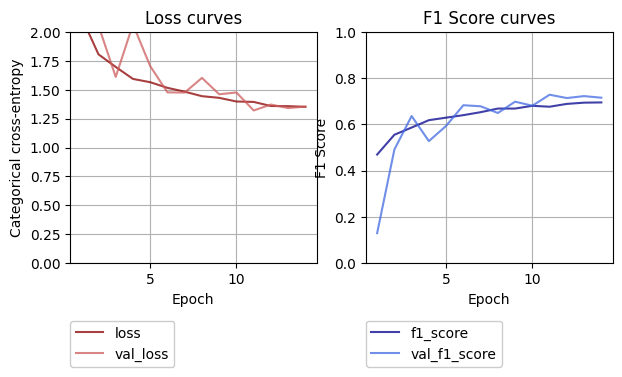

In [77]:
# Extracting evaluation metrics
acc_46, f1_46, loss_46, val_acc_46, val_f1_46, val_loss_46 = get_metrics(history46)

# Plotting the results
plot_training_history(history46)

## 9.8 Model 5 - Fully Regularized CNN
This model applies regularization more extensively, potentially leading to greater control over model complexity and better generalization (L2 regularization on both the kernel and bias weights in the dense layers, instead of applying it only to the kernel weights in the first dense layer). This model also encompasses some changes in the regularization strength setting it to 1e-5 for kernel and 1e-4 bias weights, while in the previous one it's set to 1e-3 for kernel weights only (this can impact how much the model is penalized for large weights, affecting the balance between fitting the training data and preventing overfitting).

In [91]:
# Model definition with regularization and batch normalization
model5 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(units=256, activation='relu', kernel_regularizer=regularizers.L2(1e-5),  # L2 regularization for kernel
                               bias_regularizer=regularizers.L2(1e-4)),  # L2 regularization for bias
    BatchNormalization(),
    Dropout(0.2),

    Dense(train_generator_64.num_classes, activation='softmax', kernel_regularizer=regularizers.L2(1e-5),  # L2 regularization for kernel
                               bias_regularizer=regularizers.L2(1e-4))  # L2 regularization for bias
])

model5.summary()  # Display model summary


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425,548 (5.44 MB)

 Trainable params: 1,424,140 (5.43 MB)

 Non-trainable params: 1,408 (5.50 KB)

### 9.8.1 Model with a batch size of 64, no class weights and adam optimizer

In [92]:
# Create callbacks for the model
callbacks = create_model_callbacks("history56")
model56 = compile_model_adam(model5)  # Compile the model with Adam optimizer

history56 = model56.fit(
    train_generator_64,  # Training data generator
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator_64,  # Validation data generator
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.4729 - f1_score: 0.4506 - loss: 1.8030
Epoch 1: val_f1_score improved from -inf to 0.08533, saving model to ./Callbacks_50\history56\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 36s 173ms/step - accuracy: 0.4733 - f1_score: 0.4510 - loss: 1.8015 - val_accuracy: 0.1085 - val_f1_score: 0.0853 - val_loss: 4.6926 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6004 - f1_score: 0.5895 - loss: 1.2197
Epoch 2: val_f1_score improved from 0.08533 to 0.41375, saving model to ./Callbacks_50\history56\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 34s 171ms/step - accuracy: 0.6005 - f1_score: 0.5896 - loss: 1.2195 - val_accuracy: 0.3883 - val_f1_score: 0.4138 - val_loss: 2.1680 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6499 - f1_score: 0.6349 - loss: 1.0708
Epoch 3: val_f1_score improved from 0.41375 to 0.68193, saving m

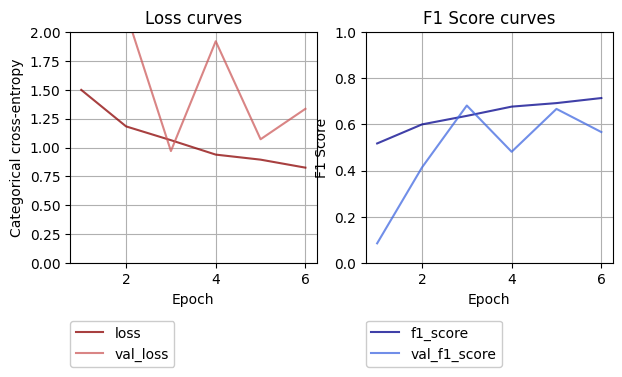

In [93]:
# Extracting evaluation metrics
acc_56, f1_56, loss_56, val_acc_56, val_f1_56, val_loss_56 = get_metrics(history56)

# Plotting the results
plot_training_history(history56)

In [94]:
# Update data3 with corrected model names
data4 = {
    "Model": ["Model46", "Model56"],  # Updated model names
    "Accuracy": [acc_46, acc_56],  # Updated accuracy values
    "F1_Score": [f1_46, f1_56],  # Updated F1 score values
    "Loss": [loss_46, loss_56],  # Updated loss values
    "Val_Accuracy": [val_acc_46, val_acc_56],  # Updated validation accuracy values
    "Val_F1_Score": [val_f1_46, val_f1_56],  # Updated validation F1 score values
    "Val_Loss": [val_loss_46, val_loss_56]  # Updated validation loss values
}

# Print the updated data3
print(pd.DataFrame(data4))

     Model  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  Val_Loss
0  Model46  0.704318  0.695344  1.352675      0.712675      0.715802  1.354653
1  Model56  0.727038  0.714305  0.825983      0.561224      0.567075  1.335258


## 9.9 Model 6 - Adding more hidden units

In [7]:
# Model definition with increased complexity and batch normalization

model6 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3), padding='same'),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(1024, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),  # Increase the number of hidden units to 512
    BatchNormalization(),
    Dropout(0.2),

    Dense(train_generator_16_1.num_classes, activation='softmax')
])

model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 50, 50, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 50, 50, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 64)        0         
 D)                                                              
                                                        

### 9.9.1 Batch size 32, adam optimizer and no class weights

In [96]:
# Create callbacks for the model
callbacks = create_model_callbacks("history64")
model64 = compile_model_adam(model6)  # Compile the model with Adam optimizer

history64 = model64.fit(
    train_generator_32,  # Training data generator
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator_32,  # Validation data generator
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.4323 - f1_score: 0.4041 - loss: 1.9476
Epoch 1: val_f1_score improved from -inf to 0.42149, saving model to ./Callbacks_50\history64\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 75s 183ms/step - accuracy: 0.4324 - f1_score: 0.4042 - loss: 1.9469 - val_accuracy: 0.4141 - val_f1_score: 0.4215 - val_loss: 2.1293 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5709 - f1_score: 0.5509 - loss: 1.3135
Epoch 2: val_f1_score improved from 0.42149 to 0.62153, saving model to ./Callbacks_50\history64\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 71s 181ms/step - accuracy: 0.5709 - f1_score: 0.5510 - loss: 1.3133 - val_accuracy: 0.6214 - val_f1_score: 0.6215 - val_loss: 1.2129 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6267 - f1_score: 0.6167 - loss: 1.1445
Epoch 3: val_f1_score did not improve from 0.62153

Epoch 3: Red

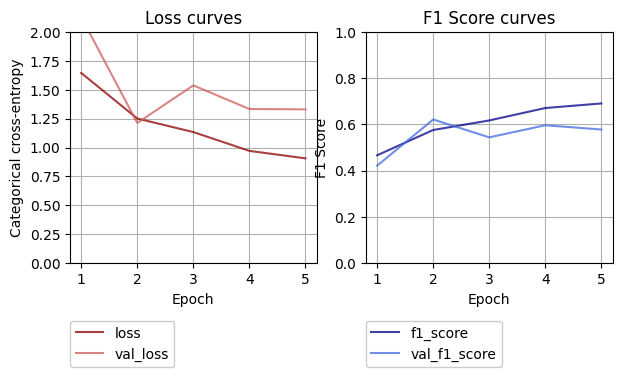

In [97]:
# Extracting evaluation metrics
acc_64, f1_64, loss_64, val_acc_64, val_f1_64, val_loss_64 = get_metrics(history64)

# Plotting the results
plot_training_history(history64)

### 9.9.2 Batch size 64, adam optimizer and no class weights

In [98]:
# Create callbacks for the model
callbacks = create_model_callbacks("history68")
model68 = compile_model_adam(model6)  # Compile the model with Adam optimizer

history68 = model68.fit(
    train_generator_64,  # Training data generator
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator_64,  # Validation data generator
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.6964 - f1_score: 0.6857 - loss: 0.8958
Epoch 1: val_f1_score improved from -inf to 0.68818, saving model to ./Callbacks_50\history68\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 72s 345ms/step - accuracy: 0.6964 - f1_score: 0.6858 - loss: 0.8956 - val_accuracy: 0.6890 - val_f1_score: 0.6882 - val_loss: 1.0099 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.7423 - f1_score: 0.7415 - loss: 0.7791
Epoch 2: val_f1_score did not improve from 0.68818
194/194 ━━━━━━━━━━━━━━━━━━━━ 65s 330ms/step - accuracy: 0.7423 - f1_score: 0.7415 - loss: 0.7791 - val_accuracy: 0.6316 - val_f1_score: 0.6186 - val_loss: 1.1526 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.7576 - f1_score: 0.7562 - loss: 0.7393
Epoch 3: val_f1_score did not improve from 0.68818
194/194 ━━━━━━━━━━━━━━━━━━━━ 64s 328ms/step - accuracy: 0.7576 - f1_score: 0.7562 - l

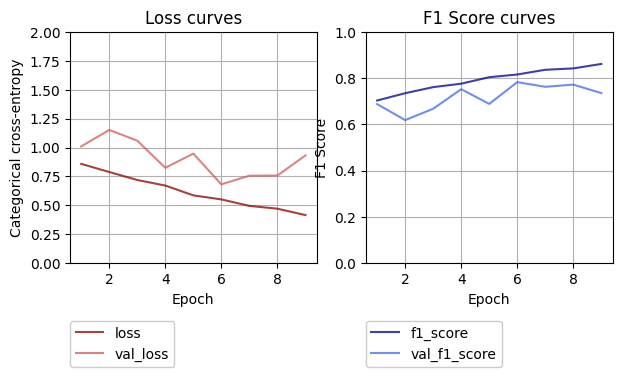

In [99]:
# Extracting evaluation metrics
acc_68, f1_68, loss_68, val_acc_68, val_f1_68, val_loss_68 = get_metrics(history68)

# Plotting the results
plot_training_history(history68)

In [100]:
# Update data3 with corrected model names
data5 = {
    "Model": ["Model64", "Model68"],  # Updated model names
    "Accuracy": [acc_64, acc_68],  # Updated accuracy values
    "F1_Score": [f1_64, f1_68],  # Updated F1 score values
    "Loss": [loss_64, loss_68],  # Updated loss values
    "Val_Accuracy": [val_acc_64, val_acc_68],  # Updated validation accuracy values
    "Val_F1_Score": [val_f1_64, val_f1_68],  # Updated validation F1 score values
    "Val_Loss": [val_loss_64, val_loss_68]  # Updated validation loss values
}

# Print the updated data3
print(pd.DataFrame(data5))

     Model  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  Val_Loss
0  Model64  0.698437  0.690896  0.906399      0.583781      0.578111  1.330735
1  Model68  0.861424  0.861924  0.415383      0.732009      0.735757  0.931517
